In [3]:
#Importing
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Loading and Inspection

In [4]:
# 1. Loading the Box Office Mojo (CSV) file 
bom = pd.read_csv("../Data/bom.movie_gross.csv")
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
bom.shape

(3387, 5)

In [6]:
#2. Loading budgets and grosses
tn = pd.read_csv("../Data/tn.movie_budgets.csv")
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [7]:
tn.shape

(5782, 6)

In [8]:
#3. Connecting to the IMDB database 
conn = sqlite3.connect("../im.db/im.db")
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [9]:
movie_basics  = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [10]:
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [11]:
conn.close()

# Data Cleaning and Preparation

**Cleaning the Budget and Gross Dataset**

In [12]:
#Cleaned copy
tn_clean = tn.copy()

In [13]:
#Displaying first five rows
tn_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [14]:
#Checking data types
tn_clean.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [15]:
#Removing dollar signs ($) and commas (,) from money columns,
#Converting them from text to numbers (float type)
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

In [16]:
#Re-checking data types
tn_clean.dtypes

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object

In [17]:
#Checking for null values
tn_clean.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [18]:
#Checking for duplicates
tn_clean.duplicated().value_counts()

False    5782
dtype: int64

In [19]:
#Creating a 'profit' column
# Profit = worldwide gross - production budget
tn_clean["profit"] = tn_clean["worldwide_gross"] - tn_clean["production_budget"]

In [20]:
#Cleaning up movie names to make them lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()

In [21]:
tn_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,5,"Dec 15, 2017",star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08


In [22]:
tn_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,profit
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,5.989970e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,1.460889e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,-2.002376e+08
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,-2.189071e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,8.550286e+06
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,6.096850e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09


In [23]:
tn_clean.shape

(5782, 7)

In [24]:
#Creating a cleaned csv file
tn_clean.to_csv("cleaned-tn.movies_budgets.csv", index=False)

**Loading and Cleaning IMDB Data**

In [25]:
#Connecting to the IMDB database
conn = sqlite3.connect("../im.db/im.db")

In [26]:
#Reading only the columns we need from the two main tables
movie_basics = pd.read_sql("SELECT primary_title, start_year, genres FROM movie_basics;", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

In [27]:
#Closing the connection
conn.close()

In [28]:
#Clean movie titles
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [29]:
movie_basics.head()

,primary_title,start_year,genres
0,sunghursh,2013,"Action,Crime,Drama"
1,one day before the rainy season,2019,"Biography,Drama"
2,the other side of the wind,2018,Drama
3,sabse bada sukh,2018,"Comedy,Drama"
4,the wandering soap opera,2017,"Comedy,Drama,Fantasy"


In [30]:
#Checking for null values
movie_basics.isna().sum()

primary_title       0
start_year          0
genres           5408
dtype: int64

In [31]:
movie_basics.shape

(146144, 3)

In [32]:
#Checking the missing values in terms of percentages
a = movie_basics.shape

nan_percent = (movie_basics.isna().sum() / a[0])*100 # total percent of missing values per column
nan_percent

primary_title    0.00000
start_year       0.00000
genres           3.70046
dtype: float64

In [33]:
#Replacing any missing genres with "Unknown"
movie_basics["genres"] = movie_basics["genres"].fillna("Unknown")

In [34]:
#Renaming rating columns for consistency 
movie_ratings = movie_ratings.rename(columns={
    "averagerating": "average_rating",
    "numvotes": "num_votes"
})

In [35]:
#Displaying first five rows for movie_basics
movie_basics.head()

,primary_title,start_year,genres
0,sunghursh,2013,"Action,Crime,Drama"
1,one day before the rainy season,2019,"Biography,Drama"
2,the other side of the wind,2018,Drama
3,sabse bada sukh,2018,"Comedy,Drama"
4,the wandering soap opera,2017,"Comedy,Drama,Fantasy"


In [36]:
#Displaying first five rows for movie-ratings
movie_ratings.head()

,movie_id,average_rating,num_votes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


# Merging the Numbers (budgets) with IMDB (genres + ratings)

**Merging TN and IMDB Data**

In [37]:
# Making sure both title columns are lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [38]:
# Merging using movie title as the key
merged = pd.merge(
    tn_clean,
    movie_basics,
    left_on="movie",
    right_on="primary_title",
    how="inner"   # keeps only movies that appear in both datasets
)

In [39]:
merged.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,primary_title,start_year,genres
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,avatar,2011,Horror
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,pirates of the caribbean: on stranger tides,2011,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,dark phoenix,2019,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,avengers: age of ultron,2015,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",avengers: infinity war,300000000.0,678815482.0,2.048134e+09,1.748134e+09,avengers: infinity war,2018,"Action,Adventure,Sci-Fi"


In [40]:
merged.shape

(3891, 10)

# Objective 2 — Best Performing Genres

In [43]:
# Grouping by genre and calculating total and average worldwide gross
genre_gross = (
    merged.groupby("main_genre")[["worldwide_gross", "profit"]]
    .agg(total_gross=("worldwide_gross", "sum"),
         avg_gross=("worldwide_gross", "mean"),
         avg_profit=("profit", "mean"),
         movie_count=("profit", "count"))
    .sort_values("total_gross", ascending=False)
)

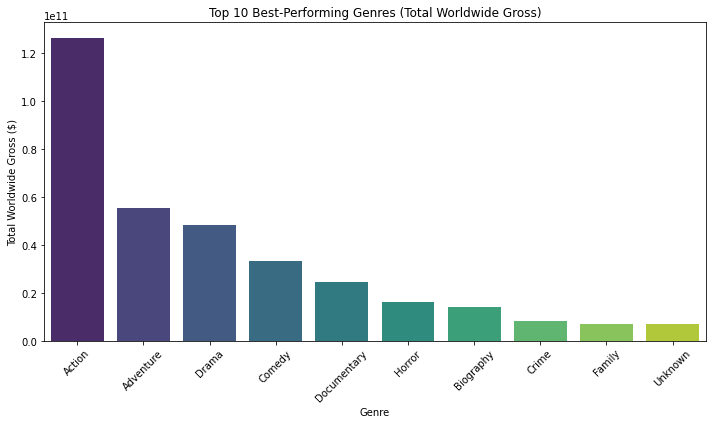

In [44]:
# Visualization – Top 10 Best-Performing Genres
plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_gross.head(10).index,
    y=genre_gross.head(10)["total_gross"],
    palette="viridis"
)
plt.title("Top 10 Best-Performing Genres (Total Worldwide Gross)")
plt.xlabel("Genre")
plt.ylabel("Total Worldwide Gross ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()